In [16]:

import urllib
import xml.etree.ElementTree as ET
import urllib
import re
import io, random
import pandas as pd
import time
from datetime import datetime
from sklearn.svm import SVR
import datetime
from skmultiflow.meta import AdaptiveRandomForestRegressor
from skmultiflow.trees import HoeffdingTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

In [17]:
df=pd.read_csv('test_complete.csv')

In [18]:
df.head()

,Unnamed: 0,DATE_TIME,PLANT_ID,SCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID.1,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,dA
0,0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0.0
1,1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0.0
2,2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0.0
3,3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0.0
4,4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0.0


In [19]:
def pred_svr(x, y, x_test):
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    y_rbf = svr_rbf.fit(np.array(x), np.ravel(y,order='C'))
    return svr_rbf.predict(x_test)

def pred_lr(x, y, x_test):
    svr_rbf = LinearRegression()
    y_rbf = svr_rbf.fit(np.array(x), np.ravel(y,order='C'))
    return svr_rbf.predict(x_test)

def pred_rff(x, y, x_test):
    arf_reg = RandomForestRegressor(random_state=123456)
    arf_reg.fit(np.array(x), np.ravel(y,order='C'))
    return arf_reg.predict(x_test)
 
def pred_hoe(x, y, x_test):
    #arf_reg = ExtraTreesRegressor(n_estimators=100, random_state=0)
    #arf_reg = linear_model.BayesianRidge()
    arf_reg = DecisionTreeRegressor(random_state=0)
    arf_reg.fit(np.array(x), np.ravel(y,order='C'))
    return arf_reg.predict(x_test)

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def algorithms_pred(df,dt_start):
    x_total = df[["AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION"]].to_numpy().tolist()
    y_total = df[["dA"]].to_numpy().tolist()
    x = x_total[:len(df)-1]
    y = y_total[:len(df)-1]
    x_test = x_total[len(df)-1:]
    y_test = y_total[len(df)-1:]
    y_pred_svr = pred_svr(x,y,x_test)
    y_pred_lr = pred_lr(x,y,x_test)
    y_pred_rff = pred_rff(x,y,x_test)
    y_pred_hoe = pred_hoe(x,y,x_test)
    
    ereg = VotingRegressor(estimators=[('gb', LinearRegression()), ('rf', AdaptiveRandomForestRegressor(random_state=123456)),
                                       ('lr', DecisionTreeRegressor(random_state=0))])
    ereg = ereg.fit(np.array(x), np.ravel(y,order='C'))
    y_pred_ensemb = ereg.predict(x_test)
    #y_pred_ensemb = (1/3)*np.add(np.add(y_pred_rff,y_pred_lr),y_pred_hoe)
    
    if(y_test[0][0]!=0 and y_pred_lr!=0 and y_pred_rff!=0 and y_pred_hoe!=0):
#         if(y_test[0][0]==0):
#             y_test[0][0]+=1
#             y_pred_hoe[0]+=1
#             y_pred_rff[0]+=1
#             y_pred_lr[0]+=1
        print(y_test ,y_pred_lr, y_pred_rff, y_pred_hoe, y_pred_ensemb)
        print(dt_start)
        MAPE_list_svr.append([y_test[0][0],y_pred_svr[0]])
        MAPE_list.append([y_test[0][0],y_pred_lr[0]])
        MAPE_list2.append([y_test[0][0],y_pred_rff[0]])
        MAPE_list3.append([y_test[0][0],y_pred_hoe[0]])
        MAPE_list_ensemb.append([y_test[0][0],y_pred_ensemb[0]])
        
# def otherAlgorithm(df):
#     x_total = df[["AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION"]].to_numpy().tolist()
#     y_total = df[["DAILY_YIELD"]].to_numpy().tolist()
#     x = x_total[:len(df)-1]
#     y MAPE_list[:len(df)-1]
#     x_test = x_total[len(df)-1:]
#     y_test = y_total[len(df)-1:]
    
#     if(y_test!=0):
#         MAPE_list2.append([y_test[0][0],y_pred[0]])

In [20]:
def dataprocess(df,start_time):
    dt_start = start_time
    dt_end = datetime.timedelta(0, 900)
    l=0
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    while(dt_start <=  datetime.datetime(2020, 6, 17, 23, 45) - datetime.timedelta(0, 900)):
        dt_end=dt_start+datetime.timedelta(0,TrainingWindow*time_sampling)
        #print(dt_start,dt_end)
        #print(sensor_list)
        #df = df.set_index(['DATE_TIME'])
        #print(df.loc[dt_start:dt_end])
        
        mask = ((df['DATE_TIME'] > dt_start) & (df['DATE_TIME'] <= dt_end))
        df_proc=df.loc[mask]
        
        print(len(df_proc))
        m=0
        for i in sensor_list:
            msk=(df_proc['SCE_KEY']==i[0])
            df_proc_sen=df_proc.loc[msk]
            #print(len(df_proc_sen),l,m)
            #print(dt_start)
            if(len(df_proc_sen)==0):
                continue
            algorithms_pred(df_proc_sen,dt_start)
            m+=1
        dt_start +=  datetime.timedelta(0, TrainingWindow*time_sampling)
        l+=1
    
    

In [21]:
#constant parameters
TrainingWindow = 30   #window size is found from historical data
PredictionWindow = 3   #prediction window/prediction horizon
time_sampling = 900 #Should be equal to data refreshing time
sensor_list=df[["SCE_KEY"]].to_numpy().tolist()
sensor_list=sensor_list[0:20]
print(sensor_list)

#main function
if __name__ == '__main__':
    MAPE_list_svr = list()
    MAPE_list = list()
    MAPE_list2 = list()
    MAPE_list3 = list()
    MAPE_list_ensemb = list()
    date=datetime.datetime(2020, 5, 15, 6, 15)
    
    
    dataprocess(df,date)
    #print(MAPE_list)
    MAPE_npArray_svr = np.array(MAPE_list_svr)
    MAPE_npArray = np.array(MAPE_list)
    MAPE_npArray2 = np.array(MAPE_list2)
    MAPE_npArray3 = np.array(MAPE_list3)
    MAPE_npArray_ensemb = np.array(MAPE_list_ensemb)
    #print(MAPE_npArray[:,0])
    mape_svr = MAPE(MAPE_npArray_svr[:,0],MAPE_npArray_svr[:,1])
    mape = MAPE(MAPE_npArray[:,0],MAPE_npArray[:,1])
    mape2 = MAPE(MAPE_npArray2[:,0],MAPE_npArray2[:,1])
    mape3 = MAPE(MAPE_npArray3[:,0],MAPE_npArray3[:,1])
    mape_ensemb = MAPE(MAPE_npArray_ensemb[:,0],MAPE_npArray_ensemb[:,1])
    print("MAPE for AMWR is: "+ str(mape_svr))
    print("MAPE for linear regression is: "+ str(mape))
    print("MAPE for rff is: "+ str(mape2))
    print("MAPE for decision tree is: "+ str(mape3))
    print("MAPE for ensemble is: "+ str(mape_ensemb))
    list1 = list()
    list1.append(mape_svr)
    list1.append(mape)
    list1.append(mape2)
    list1.append(mape3)
    list1.append(mape_ensemb)

[['1BY6WEcLGh8j5v7'], ['1IF53ai7Xc0U56Y'], ['3PZuoBAID5Wc2HD'], ['7JYdWkrLSPkdwr4'], ['McdE0feGgRqW7Ca'], ['VHMLBKoKgIrUVDU'], ['WRmjgnKYAwPKWDb'], ['ZnxXDlPa8U1GXgE'], ['ZoEaEvLYb1n2sOq'], ['adLQvlD726eNBSB'], ['bvBOhCH3iADSZry'], ['iCRJl6heRkivqQ3'], ['ih0vzX44oOqAx2f'], ['pkci93gMrogZuBj'], ['rGa61gmuvPhdLxV'], ['sjndEbLyjtCKgGv'], ['uHbuxQJl8lW7ozc'], ['wCURE6d3bPkepu2'], ['z9Y9gH1T5YWrNuG'], ['zBIq5rxdHJRwDNY']]
660
[[8202.875]] [8775.69791296] [7953.2365] [6982.7571431] [7907.48313707]
2020-05-15 06:15:00
[[8491.4428569]] [8676.32533796] [7854.45267852] [7401.4125] [8239.03139491]
2020-05-15 06:15:00
[[8567.1428569]] [8771.61115355] [8207.53178581] [7747.1375] [8373.93891414]
2020-05-15 06:15:00
[[8477.525]] [8747.57429749] [7958.51778567] [8756.1142853] [8661.36095136]
2020-05-15 06:15:00
[[8523.0999999]] [8326.02397188] [7989.7511785] [7413.3285714] [8046.83038758]
2020-05-15 06:15:00
[[8774.425]] [9052.40157482] [8371.44196439] [9020.8714289] [8924.92295473]
2020-05-15 06:15:0

660
[[1808.4]] [1788.8124709] [1878.55066055] [1863.6285711] [1823.69740394]
2020-05-18 01:45:00
[[1926.3857139]] [1910.55197225] [2001.58025] [1964.65] [1935.99933683]
2020-05-18 01:45:00
[[1912.2571433]] [1888.5543223] [1981.58555361] [1946.6625] [1915.96886835]
2020-05-18 01:45:00
[[1884.1857143]] [1859.69436866] [1960.12123213] [1936.0625] [1895.48818658]
2020-05-18 01:45:00
[[1939.7142861]] [1924.74589717] [2027.14817852] [2013.9] [1966.70271052]
2020-05-18 01:45:00
[[1944.6142857]] [1914.15657914] [2017.87767854] [1997.275] [1953.31091508]
2020-05-18 01:45:00
[[1909.1428574000001]] [1878.70303236] [1971.62094637] [1938.5375] [1907.5170554]
2020-05-18 01:45:00
[[1934.3]] [1913.28536369] [2012.53433912] [1994.1857141] [1953.04749839]
2020-05-18 01:45:00
[[1847.3875]] [1846.95634] [1937.20942857] [1900.4714286] [1872.6839217]
2020-05-18 01:45:00
[[1956.8142856]] [1938.55534348] [2031.34348215] [1992.7625] [1963.59376012]
2020-05-18 01:45:00
[[1779.075]] [1769.22413725] [1855.5733926

[[13567.099997]] [12654.45771245] [13524.19910733] [13704.8] [13266.90223513]
2020-05-20 06:15:00
[[13294.240000000002]] [12444.53725829] [13254.94567805] [13188.725] [12954.45646568]
2020-05-20 06:15:00
[[13586.16]] [13286.60621126] [13729.52978553] [13581.099996] [13602.30403479]
2020-05-20 06:15:00
[[12699.68333]] [13038.89485259] [13348.21924934] [13223.714281] [13277.37776598]
2020-05-20 06:15:00
[[13805.48]] [12825.91079613] [13717.43337565] [14025.57143] [13449.25637708]
2020-05-20 06:15:00
[[12249.633337]] [11855.09748908] [12321.12734072] [12241.100003] [12160.71622187]
2020-05-20 06:15:00
[[13684.350003]] [12535.27165587] [13256.20107142] [13508.514289] [13068.02158135]
2020-05-20 06:15:00
[[13231.86]] [12698.29482965] [13138.0515707] [13039.2] [13018.18545118]
2020-05-20 06:15:00
[[13220.56667]] [12329.16327725] [13082.89817669] [13328.414283] [12865.65273068]
2020-05-20 06:15:00
[[13491.14]] [12295.22278538] [13065.19601911] [13342.528576] [12859.71233945]
2020-05-20 06:15:

[[10135.0571429]] [10141.14392605] [9024.79900003] [9419.8375] [9959.78938034]
2020-05-23 01:45:00
[[9948.357143]] [10048.44000719] [8928.29196418] [9303.585714] [9850.29970063]
2020-05-23 01:45:00
[[9943.8000003]] [9954.34167049] [8842.69667856] [9232.4625] [9763.8935677]
2020-05-23 01:45:00
[[9621.985713899998]] [9631.16001117] [8536.98682141] [8894.8375] [9389.71296511]
2020-05-23 01:45:00
[[10303.285714]] [10324.69947974] [9180.69432136] [9517.7875] [10091.88477003]
2020-05-23 01:45:00
[[9070.899999700001]] [9116.34885061] [8075.68366071] [8430.625] [8902.42948339]
2020-05-23 01:45:00
[[9774.485713899998]] [9772.80077477] [8645.74519637] [9009.125] [9521.54887647]
2020-05-23 01:45:00
[[9681.514286]] [9721.52506358] [8622.14353566] [8991.3] [9499.14305643]
2020-05-23 01:45:00
[[9638.3857139]] [9565.54471791] [8480.49857141] [8783.6125] [9298.15657439]
2020-05-23 01:45:00
[[8500.357142399998]] [8436.79625914] [7467.53658925] [7729.85] [8190.98487951]
2020-05-23 01:45:00
[[9732.014286

[[11677.671426]] [11463.00828929] [11733.3262855] [11717.314286] [11662.50368858]
2020-05-25 06:15:00
[[13019.499996999999]] [12794.75222097] [12967.99301239] [12892.8875] [12960.35635319]
2020-05-25 06:15:00
[[12570.900001]] [13350.98942374] [12422.6578935] [12269.75] [12816.08000076]
2020-05-25 06:15:00
[[12938.714281]] [12698.99025343] [12887.8387855] [12720.475] [12844.96344695]
2020-05-25 06:15:00
[[12930.2625]] [12739.79657584] [12868.11544721] [12734.25714] [12852.93916249]
2020-05-25 06:15:00
[[12835.642859]] [12554.10107553] [12785.85389299] [12715.885717] [12747.01482731]
2020-05-25 06:15:00
[[12979.214289]] [12728.57033025] [12969.8524644] [12857.2125] [12913.12436606]
2020-05-25 06:15:00
[[13033.9]] [12821.54778198] [13021.4061434] [12990.642859] [12985.99976675]
2020-05-25 06:15:00
[[12897.628569]] [12655.06967845] [12887.76114456] [12860.171433] [12840.24426195]
2020-05-25 06:15:00
[[12363.514286]] [12177.76796312] [12268.90525577] [12077.7375] [12245.91808888]
2020-05-25

[[9641.7875]] [9324.61633081] [8487.33605365] [8957.5571429] [9200.76674465]
2020-05-28 01:45:00
[[9641.699999599998]] [9399.21038837] [8540.50894648] [9019.825] [9268.88127681]
2020-05-28 01:45:00
[[9760.5875]] [9452.93608916] [8601.22076768] [9077.4999997] [9323.52795073]
2020-05-28 01:45:00
[[9687.475]] [9397.71703191] [8543.21164257] [8999.585714] [9259.41622896]
2020-05-28 01:45:00
[[9728.9125]] [9531.86063352] [8628.05180375] [9083.4285717] [9372.52167703]
2020-05-28 01:45:00
[[9218.8625]] [8930.0358638] [8110.82251782] [8561.3714286] [8808.70554216]
2020-05-28 01:45:00
660
[[3920.8857141000003]] [4061.62722265] [4122.50864304] [4331.3857147] [4196.31337148]
2020-05-28 09:15:00
[[4351.7857139]] [4798.82513328] [4687.7496787] [5118.5428574] [4754.128253]
2020-05-28 09:15:00
[[4376.5375]] [4609.16436107] [4481.07501781] [4348.1857143] [4452.62781348]
2020-05-28 09:15:00
[[4031.0571433]] [4755.23399607] [4498.04408914] [4478.175] [4538.70773144]
2020-05-28 09:15:00
[[4007.9857144]] 

[[12875.757144]] [12928.23449074] [11775.65424883] [12370.114283] [12389.62169205]
2020-05-30 06:15:00
[[13229.0]] [13337.47765575] [12651.10942969] [13449.7625] [13150.8915359]
2020-05-30 06:15:00
660
660
660
[[8652.2714289]] [12091.97836095] [11191.32617788] [13513.842853] [12526.07040704]
2020-05-31 04:45:00
[[8883.171428399999]] [9909.98747386] [9481.41325007] [7589.9375] [8663.32692454]
2020-05-31 04:45:00
[[9171.3428574]] [10164.21781777] [9594.05407139] [7624.7625] [8821.8110993]
2020-05-31 04:45:00
[[8949.1375]] [9899.58220073] [9164.12426802] [7740.5625] [9067.33155076]
2020-05-31 04:45:00
[[10102.957143300002]] [11417.86882055] [11228.47457157] [8622.528571] [10729.23667124]
2020-05-31 04:45:00
[[9176.3125]] [11055.05586206] [11197.59289278] [10575.5875] [10920.73584164]
2020-05-31 04:45:00
[[9229.871428899998]] [9944.80964476] [10016.42303556] [11463.275] [10024.39864372]
2020-05-31 04:45:00
[[9301.0625]] [12208.01790779] [11809.68419725] [12832.928574] [12627.24298874]
2020

[[10652.2571433]] [11171.55207764] [10959.47948207] [11032.3625] [11126.48479225]
2020-06-13 07:45:00
[[10967.125]] [11470.47914991] [12073.97626675] [12179.185711] [11969.0266257]
2020-06-13 07:45:00
[[11257.342857]] [11512.21219592] [11504.96591008] [11670.5625] [11625.670292]
2020-06-13 07:45:00
[[10359.3]] [10975.48019371] [10300.04241035] [10480.9714287] [10787.16915361]
2020-06-13 07:45:00
[[11676.7]] [11277.58842829] [11773.98596482] [11220.6375] [11413.39214684]
2020-06-13 07:45:00
[[11320.114281]] [10979.36111016] [11361.67221662] [11756.157147] [11407.58624297]
2020-06-13 07:45:00
[[11201.8000014]] [11771.81541242] [11867.42583879] [11601.8375] [11603.6806537]
2020-06-13 07:45:00
[[9922.0285714]] [10440.96229047] [10758.27307116] [10931.557143] [10641.65570412]
2020-06-13 07:45:00
[[11548.14286]] [11250.52720221] [11925.25728576] [11673.025] [11547.08486915]
2020-06-13 07:45:00
[[11854.14286]] [10978.58946605] [11449.254196] [11223.125] [11208.20316237]
2020-06-13 07:45:00
[[

[[9580.6125]] [9425.50010789] [9604.85017829] [8877.1125] [9367.67485159]
2020-06-16 03:15:00
[[10797.7]] [10562.31084166] [10406.7805] [9780.3625] [10356.58681405]
2020-06-16 03:15:00
[[10475.55]] [10069.90115891] [10202.1641076] [9227.0285719] [9916.03394329]
2020-06-16 03:15:00
[[10671.1285713]] [10415.04462397] [10298.41544745] [9761.7142859] [10244.07327231]
2020-06-16 03:15:00
[[10771.771428700002]] [10535.45662104] [10320.6689293] [9813.1000003] [10317.67493559]
2020-06-16 03:15:00
[[10450.9125]] [10408.41824063] [10419.5763751] [9699.1875] [10273.58437309]
2020-06-16 03:15:00
[[10603.042857]] [10449.51516165] [10495.69560764] [9878.3857141] [10330.32514808]
2020-06-16 03:15:00
[[10671.8875]] [10419.74622659] [10486.01266133] [9406.3428571] [10191.89261042]
2020-06-16 03:15:00
[[10607.0125]] [10495.89088865] [10429.53342866] [9835.1125] [10349.88738441]
2020-06-16 03:15:00
[[10635.9625]] [10451.66662037] [10335.03528508] [9573.9] [10223.25944834]
2020-06-16 03:15:00
660
[[368.02

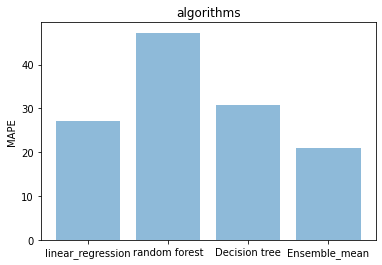

In [27]:
objects = ('linear_regression', 'random forest', 'Decision tree', 'Ensemble_mean')
y_pos = np.arange(len(objects))

plt.bar(y_pos, list1[1:], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MAPE')
plt.title('algorithms')

plt.show()

In [19]:
a_datetime = datetime.datetime(2010, 1, 1)

added_seconds = datetime.timedelta(0, 900)
#Time delta of 25 seconds

new_datetime = datetime.datetime(2020, 6, 17, 23, 45)

#Add time delta to `a_datetime`


print(new_datetime)

2020-06-17 23:45:00


In [52]:
print(mape)

36828.65896071801


In [179]:
for i in range(len(MAPE_list3)):
    print(MAPE_list3[i][0],MAPE_list3[i][1])

8202.875 6982.7571431000015
8491.4428569 7401.4125
8567.1428569 7747.1375
8477.525 8756.114285299998
8523.0999999 7413.3285714
8774.425 9020.871428899998
8571.685713899999 8815.1999997
8776.942856699998 7595.0
8433.775 8842.485714100001
8695.8571433 6891.925
7951.275 6880.5285718999985
8734.9142856 7751.042856899999
8516.071428899999 9867.55
8421.014285599998 6730.8
8371.8142854 7582.499999899998
8409.285713899997 7341.514286099998
8832.271428700002 5487.571429
8701.185713899999 7306.857142899999
8715.485713899998 6755.15
8401.757143300001 8716.375
7453.442857600003 7707.085714600002
8798.9285719 9053.571429
8933.599999700002 9476.971428099998
8003.875 9201.399999700001
8058.25 8106.571428900002
8253.575 7682.328571299999
8262.171428099999 7542.9
7614.357142699999 8421.225
8425.4875 8874.7714289
9008.357142399998 9088.700000400002
6872.657142399999 7645.500000400001
8273.471428899999 8759.975
7574.371428899999 7818.900000400003
8234.800000399999 8466.5625
8682.8875 8177.95
7987.7125 78

In [109]:
print(df)

      Unnamed: 0           DATE_TIME  PLANT_ID          SCE_KEY  DC_POWER  \
0              0 2020-05-15 00:00:00   4135001  1BY6WEcLGh8j5v7       0.0   
1             21 2020-05-15 00:15:00   4135001  1BY6WEcLGh8j5v7       0.0   
2             42 2020-05-15 00:30:00   4135001  1BY6WEcLGh8j5v7       0.0   
3             63 2020-05-15 00:45:00   4135001  1BY6WEcLGh8j5v7       0.0   
4             84 2020-05-15 01:00:00   4135001  1BY6WEcLGh8j5v7       0.0   
...          ...                 ...       ...              ...       ...   
3149       68664 2020-06-17 22:45:00   4135001  1BY6WEcLGh8j5v7       0.0   
3150       68686 2020-06-17 23:00:00   4135001  1BY6WEcLGh8j5v7       0.0   
3151       68708 2020-06-17 23:15:00   4135001  1BY6WEcLGh8j5v7       0.0   
3152       68730 2020-06-17 23:30:00   4135001  1BY6WEcLGh8j5v7       0.0   
3153       68752 2020-06-17 23:45:00   4135001  1BY6WEcLGh8j5v7       0.0   

      AC_POWER  DAILY_YIELD  TOTAL_YIELD  PLANT_ID.1       SOURCE_KEY  \
0 